In [126]:
# import pacakges
import argparse
from time import time

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
from torch.utils.data import DataLoader

from scipy.signal import savgol_filter


import matplotlib 
from matplotlib import pyplot as plt

import time as time

In [128]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
# initialize random seed 
seed = 0

# Data Pre-processing and Visualization

## 3.1 Loading the dataset

In [130]:
path = "/content/drive/My Drive/Machine Intelligence 3rd Year Intro to MI Data/Assignment3/"
data = pd.read_csv(path + "adult.csv")

## 3.2 Understanding the Dataset

In [131]:
data.shape

(48842, 15)

In [132]:
data.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

In [133]:
data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [134]:
data["income"].value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

## 3.3 Data cleaning

In [135]:
# count missing entries
col_names = data.columns
num_rows = data.shape[0]
for feature in col_names:
  total_missing_entries = data[feature].isin(["?"]).sum().sum()
  print("Total missing entries for column {name}: {num}".format(name=feature,num=total_missing_entries))

Total missing entries for column age: 0
Total missing entries for column workclass: 2799
Total missing entries for column fnlwgt: 0
Total missing entries for column education: 0
Total missing entries for column educational-num: 0
Total missing entries for column marital-status: 0
Total missing entries for column occupation: 2809
Total missing entries for column relationship: 0
Total missing entries for column race: 0
Total missing entries for column gender: 0
Total missing entries for column capital-gain: 0
Total missing entries for column capital-loss: 0
Total missing entries for column hours-per-week: 0
Total missing entries for column native-country: 857
Total missing entries for column income: 0


In [136]:
# drop missing entries

for feature in col_names:
  try:
    data = data[data[feature] != "?"]
  except ValueError:
    pass

data.shape

(45222, 15)

## 3.4 Balancing the Dataset

In [137]:
data_high_income = data[data['income'] == '>50K']
data_low_income = data[data['income'] == '<=50K']

num_minority_entries = min(len(data_high_income),len(data_low_income))
data_low_income = data_low_income.sample(n=num_minority_entries,random_state=seed)
data = pd.concat([data_low_income, data_high_income], ignore_index=True)
data

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,31,Private,34374,Prof-school,15,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,50,United-States,<=50K
1,28,State-gov,175409,Some-college,10,Separated,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
2,31,Private,102884,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,50,United-States,<=50K
3,40,Local-gov,293809,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,20,United-States,<=50K
4,29,Private,161857,HS-grad,9,Married-spouse-absent,Other-service,Not-in-family,Other,Female,0,0,40,Columbia,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22411,38,Private,139180,Bachelors,13,Divorced,Prof-specialty,Unmarried,Black,Female,15020,0,45,United-States,>50K
22412,39,Local-gov,111499,Assoc-acdm,12,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,20,United-States,>50K
22413,53,Private,321865,Masters,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,>50K
22414,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K


## 3.5 Visualizing and Understanding

In [ ]:
# util.py provided 
def verbose_print(data):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(data.head())


def random_color():
    return list(np.random.choice(range(256), size=3))


def pie_chart(dataset, column):
    col = dataset[column].value_counts()
    col_vals = col.values.tolist()
    col_types = col.axes[0].tolist()

    colors = [random_color() for i in range(len(col_types))]
    colors = ['#%02x%02x%02x' % tuple(x) for x in colors]

    fig = plt.figure(figsize=(12, 8))

    # Plot
    plt.title('Feature: {}'.format(column), fontsize=20)
    patches, texts, autotexts = plt.pie(col_vals, labels=col_types, colors=colors,
                                        autopct='%1.1f%%', shadow=True, startangle=150)
    for text, autotext in zip(texts, autotexts):
        text.set_fontsize(14)
        autotext.set_fontsize(14)

    plt.axis('equal')
    plt.show()


def autolabel(ax, rects, fontsize=14):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1*height,'%d' % int(height),
                ha='center', va='bottom',fontsize=fontsize)

def binary_bar_chart(dataset, column):
    above_list = []
    below_list = []

    col_types = dataset[column].value_counts()
    col_labels = col_types.axes[0].tolist()

    for val in col_labels:
        total = len(dataset[dataset[column] == val].index)
        above = len(dataset[(dataset[column] == val) & (dataset['income'] == '>50K')].index)
        above_list.append(above)
        below_list.append(total - above)

    ind = np.arange(len(col_labels))  # the x locations for the groups

    width = 0.40
    fig, ax = plt.subplots(figsize=(12, 7))
    above_bars = ax.bar(ind, above_list, width, color='#41f474')
    below_bars = ax.bar(ind + width, below_list, width, color='#f44295')

    ax.set_xlabel("Value", fontsize=20)
    ax.set_ylabel('Number of occurrences in dataset', fontsize=20)
    ax.set_title('Feature: {}'.format(column), fontsize=22)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(col_labels,
                       fontsize=7)
    ax.legend((above_bars, below_bars), ('Above 50k', 'Below 50k'), fontsize=17)
    autolabel(ax, above_bars, 10)
    autolabel(ax, below_bars, 10)
    plt.show()


In [ ]:
data.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,22416.000000,2.241600e+04,22416.000000,22416.000000,22416.000000,22416.000000
mean,40.329006,1.893661e+05,10.617684,2071.453828,123.980728,42.594040
std,12.590194,1.048378e+05,2.586669,10532.427796,478.371045,11.832265
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,31.000000,1.176958e+05,9.000000,0.000000,0.000000,40.000000
50%,40.000000,1.775955e+05,10.000000,0.000000,0.000000,40.000000
75%,49.000000,2.367518e+05,13.000000,0.000000,0.000000,50.000000
max,90.000000,1.268339e+06,16.000000,99999.000000,3683.000000,99.000000


In [ ]:
verbose_print(data)

   age  workclass  fnlwgt     education  educational-num  \
0   31    Private   34374   Prof-school               15   
1   28  State-gov  175409  Some-college               10   
2   31    Private  102884       HS-grad                9   
3   40  Local-gov  293809     Bachelors               13   
4   29    Private  161857       HS-grad                9   

          marital-status         occupation   relationship   race  gender  \
0          Never-married     Prof-specialty  Not-in-family  White    Male   
1              Separated       Adm-clerical  Not-in-family  White  Female   
2     Married-civ-spouse  Machine-op-inspct        Husband  White    Male   
3     Married-civ-spouse     Prof-specialty        Husband  White    Male   
4  Married-spouse-absent      Other-service  Not-in-family  Other  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0             0             0              50  United-States  <=50K  
1             0             0       

In [138]:
categorical_feats = ['workclass', 'race', 'education', 'marital-status', 'occupation',
                    'relationship', 'gender', 'native-country', 'income']

for feature in categorical_feats:
  print(f"Feature: {feature} ")
  print(data[feature].value_counts)
  print()


Feature: workclass 
<bound method IndexOpsMixin.value_counts of 0             Private
1           State-gov
2             Private
3           Local-gov
4             Private
             ...     
22411         Private
22412       Local-gov
22413         Private
22414         Private
22415    Self-emp-inc
Name: workclass, Length: 22416, dtype: object>

Feature: race 
<bound method IndexOpsMixin.value_counts of 0        White
1        White
2        White
3        White
4        Other
         ...  
22411    Black
22412    White
22413    White
22414    White
22415    White
Name: race, Length: 22416, dtype: object>

Feature: education 
<bound method IndexOpsMixin.value_counts of 0         Prof-school
1        Some-college
2             HS-grad
3           Bachelors
4             HS-grad
             ...     
22411       Bachelors
22412      Assoc-acdm
22413         Masters
22414         HS-grad
22415         HS-grad
Name: education, Length: 22416, dtype: object>

Feature: marital-status 


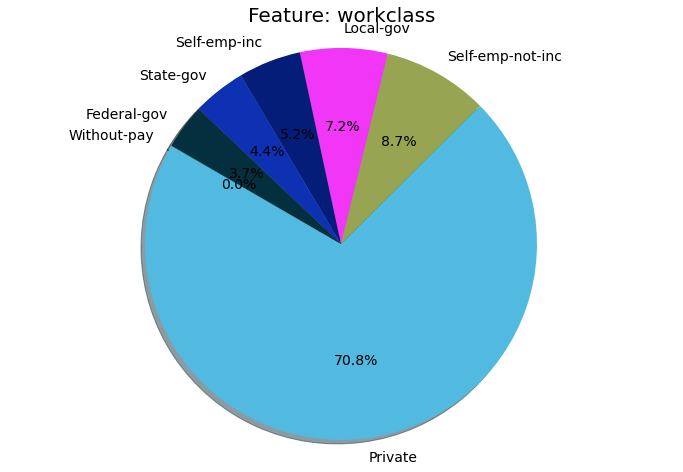

In [ ]:
pie_chart(data,categorical_feats[0])

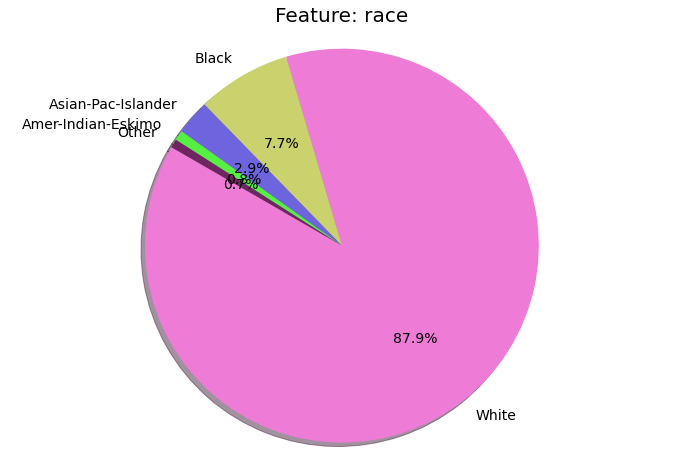

In [ ]:
pie_chart(data,categorical_feats[1])

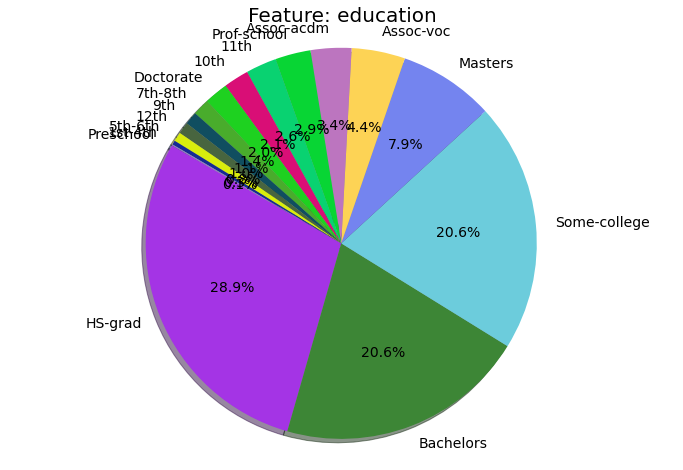

In [ ]:
pie_chart(data,categorical_feats[2])

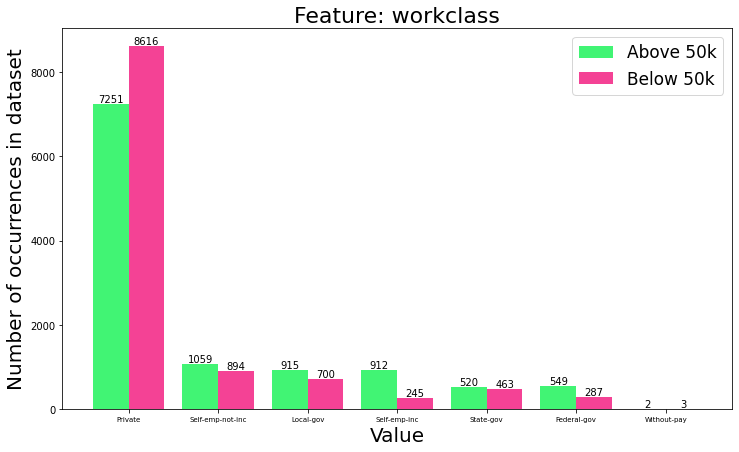

In [ ]:
binary_bar_chart(data,categorical_feats[0]) 

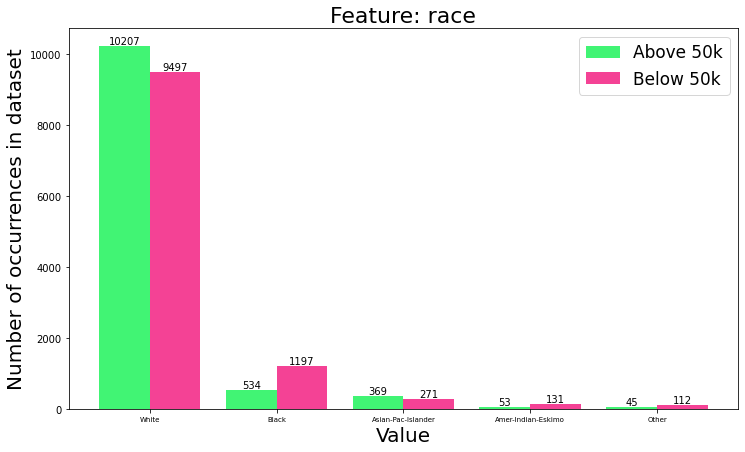

In [ ]:
binary_bar_chart(data,categorical_feats[1])

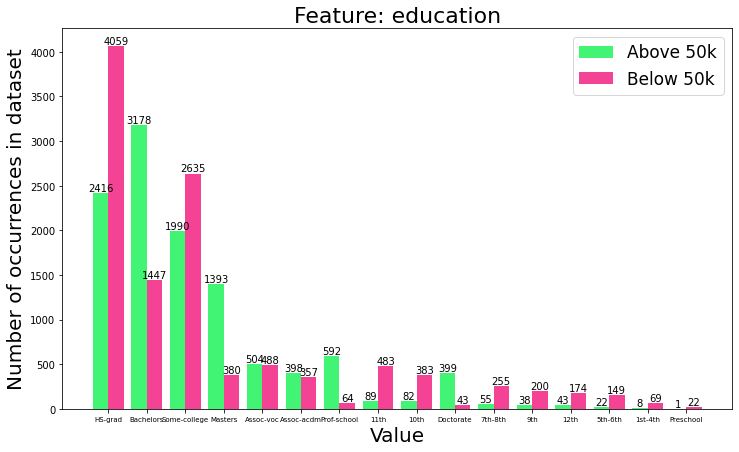

In [ ]:
binary_bar_chart(data,categorical_feats[2])

## 3.6 Pre-processing

In [139]:
# normalize continuous features
continuous_features = data.select_dtypes(include=np.number)
for feature in continuous_features.columns:
  column_mean = continuous_features[feature].mean()
  column_std = continuous_features[feature].std()
  continuous_features[feature] = (continuous_features - column_mean) / column_std
cts_data = continuous_features.values
cts_data.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(22416, 6)

In [140]:
# Drop the "income" column in data, remove "income" from categorical_feats, extract categorical labels and convert to one-hot vectors
label_encoder = LabelEncoder()
if 'income' in data.columns:  
    y = data['income'].values
    y = label_encoder.fit_transform(y)
    data = data.drop(columns=['income'])
    categorical_feats.remove('income')

cat_labels = []

labelencoder = LabelEncoder()
for col in categorical_feats:
    cLabel = labelencoder.fit_transform(data[col])
    cat_labels += [cLabel]
cat_labels = (np.array(cat_labels)).T
print(cat_labels.shape)


onehot_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore") 
cat_onehot = onehot_encoder.fit_transform(cat_labels)
print(cat_onehot.shape)




(22416, 8)
(22416, 97)


In [141]:
# Stich together the categorical and continuous features into the finalized training data X
X = np.concatenate([cts_data,cat_onehot],axis=1)
print("Shape of X = ",X.shape)

Shape of X =  (22416, 103)


## 3.7 Train-validation split

In [142]:
# splitting the features and lables into training and testing sets,with a test size of 0.2
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=seed)

# Model Training

## 4.1 Dataset


In [143]:
# define Adult Dataset class 
class AdultDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
      self.X = X
      self.y = y

    def __len__(self):
      return len(self.X)

    def __getitem__(self, index):
      # generates one sample of data
      return torch.from_numpy(self.X[index]),self.y[index]

## 4.2 DataLoader

In [144]:
def load_data(batch_size,train_data,test_data):
  train_data = AdultDataset(X_train,y_train)
  test_data = AdultDataset(X_test,y_test)

  train_loader = DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)
  val_loader = DataLoader(dataset=test_data,batch_size=batch_size)
  return train_loader, val_loader

## 4.3 Model

In [145]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size,hidden_layer):
      super(MultiLayerPerceptron, self).__init__()
      self.fc1 = nn.Linear(input_size,hidden_layer)
      self.layer_out = nn.Linear(hidden_layer,1)
      self.relu = nn.ReLU()
      self.sigmoid = nn.Sigmoid()
    def forward(self, features):
      x = self.relu(self.fc1(features))
      x = self.layer_out(x)
      x = self.sigmoid(x)
      return x

'''
class MultiLayerPerceptron2(nn.Module):
    def __init__(self, input_size,hidden_layer):
      super(MultiLayerPerceptron2, self).__init__()
      self.fc1 = nn.Linear(input_size,hidden_layer)
      #self.fc2 = nn.Linear(hidden_layer,hidden_layer)
      #self.fc3 = nn.Linear(hidden_layer,hidden_layer)
      self.layer_out = nn.Linear(hidden_layer,1)
      self.tanh = nn.Tanh()
      self.sigmoid = nn.Sigmoid()
    def forward(self, features):
      x = self.tanh(self.fc1(features))
      #x = self.fc2(x)
      #x = self.fc3(x)
      x = self.layer_out(x)
      x = self.sigmoid(x)
      return x

class MultiLayerPerceptron3(nn.Module):
    def __init__(self, input_size,hidden_layer):
      super(MultiLayerPerceptron3, self).__init__()
      self.fc1 = nn.Linear(input_size,hidden_layer)
      #self.fc2 = nn.Linear(hidden_layer,hidden_layer)
      #self.fc3 = nn.Linear(hidden_layer,hidden_layer)
      self.layer_out = nn.Linear(hidden_layer,1)
      
      self.sigmoid = nn.Sigmoid()
    def forward(self, features):
      x = self.sigmoid(self.fc1(features))
      #x = self.fc2(x)
      #x = self.fc3(x)
      x = self.layer_out(x)
      x = self.sigmoid(x)
      return x
'''


'\nclass MultiLayerPerceptron2(nn.Module):\n    def __init__(self, input_size,hidden_layer):\n      super(MultiLayerPerceptron2, self).__init__()\n      self.fc1 = nn.Linear(input_size,hidden_layer)\n      #self.fc2 = nn.Linear(hidden_layer,hidden_layer)\n      #self.fc3 = nn.Linear(hidden_layer,hidden_layer)\n      self.layer_out = nn.Linear(hidden_layer,1)\n      self.tanh = nn.Tanh()\n      self.sigmoid = nn.Sigmoid()\n    def forward(self, features):\n      x = self.tanh(self.fc1(features))\n      #x = self.fc2(x)\n      #x = self.fc3(x)\n      x = self.layer_out(x)\n      x = self.sigmoid(x)\n      return x\n\nclass MultiLayerPerceptron3(nn.Module):\n    def __init__(self, input_size,hidden_layer):\n      super(MultiLayerPerceptron3, self).__init__()\n      self.fc1 = nn.Linear(input_size,hidden_layer)\n      #self.fc2 = nn.Linear(hidden_layer,hidden_layer)\n      #self.fc3 = nn.Linear(hidden_layer,hidden_layer)\n      self.layer_out = nn.Linear(hidden_layer,1)\n      \n      self

## 4.4 Loss function and Optimizer

In [146]:
def load_model(lr,hidden_layer):
  model = MultiLayerPerceptron(input_size=103,hidden_layer=hidden_layer)
  loss_fcn = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(),lr=lr)
  return model, loss_fcn, optimizer


## 4.6 Validation

In [147]:
def evaluate(model, val_loader):
  model.eval()
  total_corr = 0
  for i,data in enumerate(val_loader):
    inputs,labels = data
    y_pred = model(inputs.float())
    for i in range (len(labels)):
      if (y_pred[i].item() > 0.5):
        r = 1
      else:
        r = 0
      if (r == labels[i].item()):
        total_corr += 1

  return float(total_corr)/len(val_loader.dataset)

def accuracy(prediction,label):
  total_corr = 0
  prediction = prediction.reshape((len(prediction),))
  label = list(label)
  for i in range (len(prediction)):
    if (prediction[i] == label[i]):
      total_corr += 1
  return (total_corr/len(label))

def count_num_corr_predicts(prediction,label):
  total_corr = 0
  prediction = prediction.reshape((len(prediction),))
  label = list(label)
  for i in range (len(prediction)):
    if (prediction[i] == label[i]):
      total_corr += 1
  return total_corr

## 4.5 Training Loop

(Epoch,Batch) = (1,10)
Number of correct predictions: 32
Avg Training Accuracy (10 most recent batches): 0.511
Validation Accuracy: 0.496
Loss: 0.247


(Epoch,Batch) = (1,20)
Number of correct predictions: 41
Avg Training Accuracy (10 most recent batches): 0.588
Validation Accuracy: 0.701
Loss: 0.243


(Epoch,Batch) = (1,30)
Number of correct predictions: 44
Avg Training Accuracy (10 most recent batches): 0.650
Validation Accuracy: 0.732
Loss: 0.238


(Epoch,Batch) = (1,40)
Number of correct predictions: 40
Avg Training Accuracy (10 most recent batches): 0.711
Validation Accuracy: 0.746
Loss: 0.233


(Epoch,Batch) = (1,50)
Number of correct predictions: 46
Avg Training Accuracy (10 most recent batches): 0.730
Validation Accuracy: 0.748
Loss: 0.227


(Epoch,Batch) = (1,60)
Number of correct predictions: 44
Avg Training Accuracy (10 most recent batches): 0.725
Validation Accuracy: 0.754
Loss: 0.226


(Epoch,Batch) = (1,70)
Number of correct predictions: 45
Avg Training Accuracy (10 most 

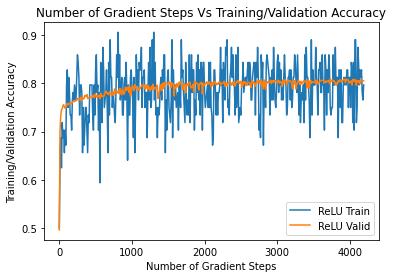

In [ ]:
def main():
  
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  batch_size = 64 #@param {type:"integer"}
  lr = 0.1 #@param {type:"number"}
  epochs = 15 #@param {type:"integer"}
  eval_every = 10 #@param {type:"integer"}
  hidden_layer = 64 #@param {tpye:"integer"}

  torch.manual_seed(seed)

  train_data = AdultDataset(torch.from_numpy(X_train),torch.from_numpy(y_train))
  test_data = AdultDataset(torch.from_numpy(X_test),torch.from_numpy(y_test))
  train_loader, val_loader = load_data(batch_size=batch_size,train_data=train_data,test_data=test_data)
  model,loss_fcn,optimizer = load_model(lr,hidden_layer)

  model.to(device)


  
  trainAccRec = []
  miniTrainAcc = []
  validAccRec = [] 


  tot_corr = 0
  num_batch = 0

  t = []
  tic = time.time()


  model.train()
  for epoch in range (1,epochs+1):
    for i,data in enumerate(train_loader,0):
      inputs,labels = data
      inputs,labels = inputs.to(device), labels.to(device)
      
      optimizer.zero_grad()
      
      predict = model(inputs.float())
      y_pred = np.where(predict > 0.5,1,0)
      
      loss = loss_fcn(input = predict.squeeze(),target=labels.float())
      loss.backward()
      optimizer.step()
      
      
      miniTrainAcc.append(accuracy(y_pred,labels))
      
      if (i % eval_every) == (eval_every - 1):
        num_batch += 1
        trainAcc = accuracy(y_pred,labels.float())
        trainAccRec.append(trainAcc)

        valAcc = evaluate(model,val_loader)
        mini_train_acc = sum(miniTrainAcc) / len(miniTrainAcc)
        validAccRec.append(valAcc)
        
        print("(Epoch,Batch) = (%d,%d)"%(epoch,i+1))
        print("Number of correct predictions: %d"%(count_num_corr_predicts(y_pred,labels)))
        print("Avg Training Accuracy (%d most recent batches): %.3f"%(eval_every,mini_train_acc))
        print("Validation Accuracy: %.3f"%valAcc)
        print("Loss: %.3f"%loss.item())
        print("\n")
        miniTrainAcc = []


  toc = time.time()
  print("Highest Validation Accuracy:%.3f"%max(validAccRec))
  print("Highest Training Accuracy:%.3f"%max(trainAccRec))
  print("Total time:%.3f"%(toc-tic))
  num_batches = list(range(num_batch)) 
  num_steps = [i * eval_every for i in num_batches]
  
  #trainAccRec = savgol_filter(trainAccRec,47,2)   
  #validAccRec = savgol_filter(validAccRec,47,2) 
    
  plt.plot(num_steps,trainAccRec,label="ReLU Train")
  plt.plot(num_steps,validAccRec,label="ReLU Valid")


  plt.legend()
  plt.xlabel("Number of Gradient Steps")
  plt.ylabel("Training/Validation Accuracy")
  plt.title("Number of Gradient Steps Vs Training/Validation Accuracy")
  
  '''

  plt.plot(t,trainAccRec,label="Training Accuracy")
  plt.plot(t,validAccRec,label="Validation Accuracy")
  plt.xlabel("Time[s]")
  plt.ylabel("Training/Validation Accuracy")
  plt.title("Time Vs. Training/Validation Accuracy")
  plt.legend()
  plt.show()
  '''



if __name__ == "__main__":
    main()

# Hyperparamters 

In [ ]:
# redefine the main function to train function for ease of calling
def train(batch_size,lr,epochs,eval_every,hidden_layer,seed,train_filter,valid_filter):
  
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


  torch.manual_seed(seed)

  train_data = AdultDataset(torch.from_numpy(X_train),torch.from_numpy(y_train))
  test_data = AdultDataset(torch.from_numpy(X_test),torch.from_numpy(y_test))
  train_loader, val_loader = load_data(batch_size=batch_size,train_data=train_data,test_data=test_data)
  model,loss_fcn,optimizer = load_model(lr,hidden_layer)
  #model2 = MultiLayerPerceptron2(input_size=103,hidden_layer=hidden_layer)
  #model3 = MultiLayerPerceptron3(input_size=103,hidden_layer=hidden_layer)
  model.to(device)
  #model2.to(device)
  #model3.to(device)

  
  trainAccRec = []
  #trainAccRec2 = []
  #trainAccRec3 = []
  miniTrainAcc = []
  validAccRec = [] 
  #validAccRec2 = []
  #validAccRec3 = []

  tot_corr = 0
  num_batch = 0

  t = []
  tic = time.time()


  model.train()
  for epoch in range (1,epochs+1):
    for i,data in enumerate(train_loader,0):
      inputs,labels = data
      inputs,labels = inputs.to(device), labels.to(device)
      
      optimizer.zero_grad()
      
      predict = model(inputs.float())
      y_pred = np.where(predict > 0.5,1,0)
      
      loss = loss_fcn(input = predict.squeeze(),target=labels.float())
      loss.backward()
      optimizer.step()
      
      
      miniTrainAcc.append(accuracy(y_pred,labels))
      
      if (i % eval_every) == (eval_every - 1):
        num_batch += 1
        trainAcc = accuracy(y_pred,labels.float())
        trainAccRec.append(trainAcc)

        valAcc = evaluate(model,val_loader)
        mini_train_acc = sum(miniTrainAcc) / len(miniTrainAcc)
        validAccRec.append(valAcc)
        
        #t.append(time.time()-tic)
        print("(Epoch,Batch) = (%d,%d)"%(epoch,i+1))
        print("Number of correct predictions: %d"%(count_num_corr_predicts(y_pred,labels)))
        print("Avg Training Accuracy (%d most recent batches): %.3f"%(eval_every,mini_train_acc))
        print("Validation Accuracy: %.3f"%valAcc)
        print("Loss: %.3f"%loss.item())
        print("\n")
        miniTrainAcc = []


  toc = time.time()
  print("Highest Validation Accuracy:%.3f"%max(validAccRec))
  print("Highest Training Accuracy:%.3f"%max(trainAccRec))
  print("Total time:%.3f"%(toc-tic))
  num_batches = list(range(num_batch)) 
  num_steps = [i * eval_every for i in num_batches]
  if (train_filter):
    trainAccRec = savgol_filter(trainAccRec,47,2) 
  if (valid_filter):  
    validAccRec = savgol_filter(validAccRec,47,2) 
    
  plt.plot(num_steps,trainAccRec,label="ReLU Train")
  plt.plot(num_steps,validAccRec,label="ReLU Valid")


  plt.legend()
  plt.xlabel("Number of Gradient Steps")
  plt.ylabel("Training/Validation Accuracy")
  plt.title("Number of Gradient Steps Vs Training/Validation Accuracy")
  
  '''

  plt.plot(t,trainAccRec,label="Training Accuracy")
  plt.plot(t,validAccRec,label="Validation Accuracy")
  plt.xlabel("Time[s]")
  plt.ylabel("Training/Validation Accuracy")
  plt.title("Time Vs. Training/Validation Accuracy")
  plt.legend()
  plt.show()
  '''

## 5.1 Learning Rate

(Epoch,Batch) = (1,10)
Number of correct predictions: 32
Avg Training Accuracy (10 most recent batches): 0.511
Validation Accuracy: 0.496
Loss: 0.247


(Epoch,Batch) = (1,20)
Number of correct predictions: 41
Avg Training Accuracy (10 most recent batches): 0.588
Validation Accuracy: 0.701
Loss: 0.243


(Epoch,Batch) = (1,30)
Number of correct predictions: 44
Avg Training Accuracy (10 most recent batches): 0.650
Validation Accuracy: 0.732
Loss: 0.238


(Epoch,Batch) = (1,40)
Number of correct predictions: 40
Avg Training Accuracy (10 most recent batches): 0.711
Validation Accuracy: 0.746
Loss: 0.233


(Epoch,Batch) = (1,50)
Number of correct predictions: 46
Avg Training Accuracy (10 most recent batches): 0.730
Validation Accuracy: 0.748
Loss: 0.227


(Epoch,Batch) = (1,60)
Number of correct predictions: 44
Avg Training Accuracy (10 most recent batches): 0.725
Validation Accuracy: 0.754
Loss: 0.226


(Epoch,Batch) = (1,70)
Number of correct predictions: 45
Avg Training Accuracy (10 most 

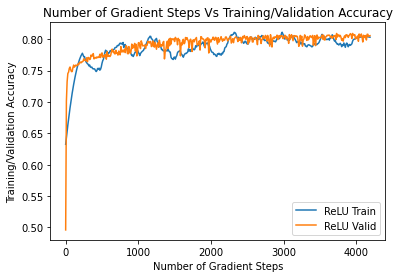

In [ ]:
batch_size = 64 #@param {type:"integer"}

lr = 0.1 #@param {type:"number"}
epochs = 15 #@param {type:"integer"}
eval_every = 10 #@param {type:"integer"}
hidden_layer = 64 #@param {tpye:"integer"}

train(batch_size = batch_size, lr=lr,epochs=epochs,
      eval_every = eval_every, hidden_layer = hidden_layer,
      seed=seed,train_filter=True,valid_filter=False)

(Epoch,Batch) = (1,10)
Number of correct predictions: 31
Avg Training Accuracy (10 most recent batches): 0.581
Validation Accuracy: 0.499
Loss: 0.256


(Epoch,Batch) = (1,20)
Number of correct predictions: 46
Avg Training Accuracy (10 most recent batches): 0.641
Validation Accuracy: 0.756
Loss: 0.188


(Epoch,Batch) = (1,30)
Number of correct predictions: 46
Avg Training Accuracy (10 most recent batches): 0.684
Validation Accuracy: 0.755
Loss: 0.187


(Epoch,Batch) = (1,40)
Number of correct predictions: 48
Avg Training Accuracy (10 most recent batches): 0.752
Validation Accuracy: 0.734
Loss: 0.168


(Epoch,Batch) = (1,50)
Number of correct predictions: 46
Avg Training Accuracy (10 most recent batches): 0.730
Validation Accuracy: 0.762
Loss: 0.186


(Epoch,Batch) = (1,60)
Number of correct predictions: 38
Avg Training Accuracy (10 most recent batches): 0.720
Validation Accuracy: 0.608
Loss: 0.261


(Epoch,Batch) = (1,70)
Number of correct predictions: 53
Avg Training Accuracy (10 most 

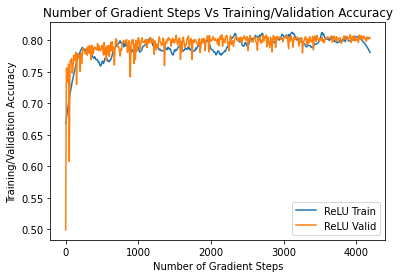

In [ ]:
batch_size = 64 #@param {type:"integer"}

lr = 1 #@param {type:"number"}
epochs = 15 #@param {type:"integer"}
eval_every = 10 #@param {type:"integer"}
hidden_layer = 64 #@param {tpye:"integer"}

train(batch_size = batch_size, lr=lr,epochs=epochs,
      eval_every = eval_every, hidden_layer = hidden_layer,
      seed=seed,train_filter=True,valid_filter=False)

(Epoch,Batch) = (1,10)
Number of correct predictions: 31
Avg Training Accuracy (10 most recent batches): 0.528
Validation Accuracy: 0.501
Loss: 0.516


(Epoch,Batch) = (1,20)
Number of correct predictions: 29
Avg Training Accuracy (10 most recent batches): 0.487
Validation Accuracy: 0.501
Loss: 0.547


(Epoch,Batch) = (1,30)
Number of correct predictions: 29
Avg Training Accuracy (10 most recent batches): 0.512
Validation Accuracy: 0.501
Loss: 0.547


(Epoch,Batch) = (1,40)
Number of correct predictions: 27
Avg Training Accuracy (10 most recent batches): 0.506
Validation Accuracy: 0.501
Loss: 0.578


(Epoch,Batch) = (1,50)
Number of correct predictions: 28
Avg Training Accuracy (10 most recent batches): 0.500
Validation Accuracy: 0.501
Loss: 0.562


(Epoch,Batch) = (1,60)
Number of correct predictions: 37
Avg Training Accuracy (10 most recent batches): 0.506
Validation Accuracy: 0.501
Loss: 0.422


(Epoch,Batch) = (1,70)
Number of correct predictions: 30
Avg Training Accuracy (10 most 

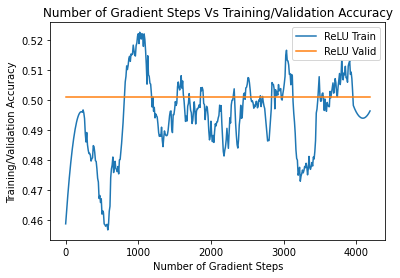

In [ ]:
batch_size = 64 #@param {type:"integer"}

lr = 100 #@param {type:"number"}
epochs = 15 #@param {type:"integer"}
eval_every = 10 #@param {type:"integer"}
hidden_layer = 64 #@param {tpye:"integer"}

train(batch_size = batch_size, lr=lr,epochs=epochs,
      eval_every = eval_every, hidden_layer = hidden_layer,
      seed=seed,train_filter=True,valid_filter=False)

## 5.3 Batch Size

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


(Epoch,Batch) = (1,1000)
Number of correct predictions: 1
Avg Training Accuracy (1000 most recent batches): 0.697
Validation Accuracy: 0.758
Loss: 0.091


(Epoch,Batch) = (1,2000)
Number of correct predictions: 1
Avg Training Accuracy (1000 most recent batches): 0.734
Validation Accuracy: 0.756
Loss: 0.216


(Epoch,Batch) = (1,3000)
Number of correct predictions: 1
Avg Training Accuracy (1000 most recent batches): 0.776
Validation Accuracy: 0.745
Loss: 0.181


(Epoch,Batch) = (1,4000)
Number of correct predictions: 1
Avg Training Accuracy (1000 most recent batches): 0.752
Validation Accuracy: 0.780
Loss: 0.075


(Epoch,Batch) = (1,5000)
Number of correct predictions: 1
Avg Training Accuracy (1000 most recent batches): 0.771
Validation Accuracy: 0.779
Loss: 0.009


(Epoch,Batch) = (1,6000)
Number of correct predictions: 0
Avg Training Accuracy (1000 most recent batches): 0.767
Validation Accuracy: 0.752
Loss: 0.307


(Epoch,Batch) = (1,7000)
Number of correct predictions: 1
Avg Training

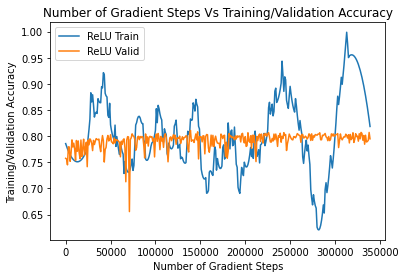

In [ ]:
batch_size = 1 #@param {type:"integer"}

lr = 0.1 #@param {type:"number"}
epochs = 20 #@param {type:"integer"}
eval_every = 1000 #@param {type:"integer"}
hidden_layer = 64 #@param {tpye:"integer"}

train(batch_size = batch_size, lr=lr,epochs=epochs,
      eval_every = eval_every, hidden_layer = hidden_layer,
      seed=seed,train_filter=True,valid_filter=False)

(Epoch,Batch) = (1,10)
Number of correct predictions: 32
Avg Training Accuracy (10 most recent batches): 0.511
Validation Accuracy: 0.496
Loss: 0.247


(Epoch,Batch) = (1,20)
Number of correct predictions: 41
Avg Training Accuracy (10 most recent batches): 0.588
Validation Accuracy: 0.701
Loss: 0.243


(Epoch,Batch) = (1,30)
Number of correct predictions: 44
Avg Training Accuracy (10 most recent batches): 0.650
Validation Accuracy: 0.732
Loss: 0.238


(Epoch,Batch) = (1,40)
Number of correct predictions: 40
Avg Training Accuracy (10 most recent batches): 0.711
Validation Accuracy: 0.746
Loss: 0.233


(Epoch,Batch) = (1,50)
Number of correct predictions: 46
Avg Training Accuracy (10 most recent batches): 0.730
Validation Accuracy: 0.748
Loss: 0.227


(Epoch,Batch) = (1,60)
Number of correct predictions: 44
Avg Training Accuracy (10 most recent batches): 0.725
Validation Accuracy: 0.754
Loss: 0.226


(Epoch,Batch) = (1,70)
Number of correct predictions: 45
Avg Training Accuracy (10 most 

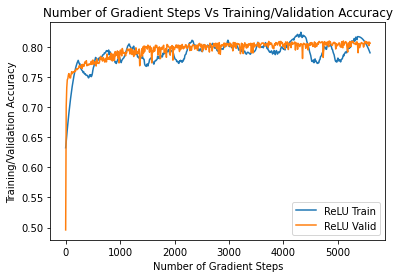

In [ ]:
batch_size = 64 #@param {type:"integer"}

lr = 0.1 #@param {type:"number"}
epochs = 20 #@param {type:"integer"}
eval_every = 10 #@param {type:"integer"}
hidden_layer = 64 #@param {tpye:"integer"}

train(batch_size = batch_size, lr=lr,epochs=epochs,
      eval_every = eval_every, hidden_layer = hidden_layer,
      seed=seed,train_filter=True,valid_filter=False)

(Epoch,Batch) = (1,1)
Number of correct predictions: 8841
Avg Training Accuracy (1 most recent batches): 0.493
Validation Accuracy: 0.485
Loss: 0.255


(Epoch,Batch) = (2,1)
Number of correct predictions: 8733
Avg Training Accuracy (1 most recent batches): 0.487
Validation Accuracy: 0.479
Loss: 0.254


(Epoch,Batch) = (3,1)
Number of correct predictions: 8613
Avg Training Accuracy (1 most recent batches): 0.480
Validation Accuracy: 0.475
Loss: 0.253


(Epoch,Batch) = (4,1)
Number of correct predictions: 8529
Avg Training Accuracy (1 most recent batches): 0.476
Validation Accuracy: 0.471
Loss: 0.252


(Epoch,Batch) = (5,1)
Number of correct predictions: 8432
Avg Training Accuracy (1 most recent batches): 0.470
Validation Accuracy: 0.471
Loss: 0.251


(Epoch,Batch) = (6,1)
Number of correct predictions: 8430
Avg Training Accuracy (1 most recent batches): 0.470
Validation Accuracy: 0.477
Loss: 0.251


(Epoch,Batch) = (7,1)
Number of correct predictions: 8496
Avg Training Accuracy (1 most 

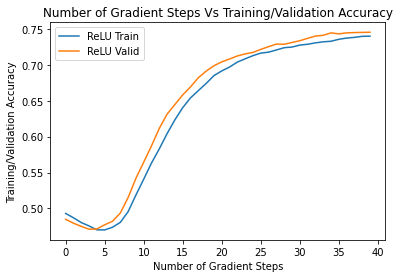

In [ ]:
batch_size = 17932 #@param {type:"integer"}

lr = 0.1 #@param {type:"number"}
epochs = 40 #@param {type:"integer"}
eval_every = 1 #@param {type:"integer"}
hidden_layer = 64 #@param {tpye:"integer"}

train(batch_size = batch_size, lr=lr,epochs=epochs,
      eval_every = eval_every, hidden_layer = hidden_layer,
      seed=seed,train_filter=False,valid_filter=False)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


(Epoch,Batch) = (1,1000)
Number of correct predictions: 1
Avg Training Accuracy (1000 most recent batches): 0.697
Validation Accuracy: 0.758
Loss: 0.091


(Epoch,Batch) = (1,2000)
Number of correct predictions: 1
Avg Training Accuracy (1000 most recent batches): 0.734
Validation Accuracy: 0.756
Loss: 0.216


(Epoch,Batch) = (1,3000)
Number of correct predictions: 1
Avg Training Accuracy (1000 most recent batches): 0.776
Validation Accuracy: 0.745
Loss: 0.181


(Epoch,Batch) = (1,4000)
Number of correct predictions: 1
Avg Training Accuracy (1000 most recent batches): 0.752
Validation Accuracy: 0.780
Loss: 0.075


(Epoch,Batch) = (1,5000)
Number of correct predictions: 1
Avg Training Accuracy (1000 most recent batches): 0.771
Validation Accuracy: 0.779
Loss: 0.009


(Epoch,Batch) = (1,6000)
Number of correct predictions: 0
Avg Training Accuracy (1000 most recent batches): 0.767
Validation Accuracy: 0.752
Loss: 0.307


(Epoch,Batch) = (1,7000)
Number of correct predictions: 1
Avg Training

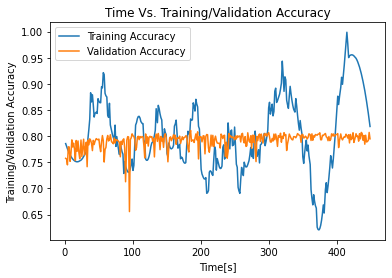

In [ ]:
def train_timeplot(batch_size,lr,epochs,eval_every,hidden_layer,seed,train_filter,valid_filter):
  
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


  torch.manual_seed(seed)

  train_data = AdultDataset(torch.from_numpy(X_train),torch.from_numpy(y_train))
  test_data = AdultDataset(torch.from_numpy(X_test),torch.from_numpy(y_test))
  train_loader, val_loader = load_data(batch_size=batch_size,train_data=train_data,test_data=test_data)
  model,loss_fcn,optimizer = load_model(lr,hidden_layer)
  #model2 = MultiLayerPerceptron2(input_size=103,hidden_layer=hidden_layer)
  #model3 = MultiLayerPerceptron3(input_size=103,hidden_layer=hidden_layer)
  model.to(device)
  #model2.to(device)
  #model3.to(device)

  
  trainAccRec = []
  #trainAccRec2 = []
  #trainAccRec3 = []
  miniTrainAcc = []
  validAccRec = [] 
  #validAccRec2 = []
  #validAccRec3 = []

  tot_corr = 0
  num_batch = 0

  t = []
  tic = time.time()


  model.train()
  for epoch in range (1,epochs+1):
    for i,data in enumerate(train_loader,0):
      inputs,labels = data
      inputs,labels = inputs.to(device), labels.to(device)
      
      optimizer.zero_grad()
      
      predict = model(inputs.float())
      y_pred = np.where(predict > 0.5,1,0)
      
      loss = loss_fcn(input = predict.squeeze(),target=labels.float())
      loss.backward()
      optimizer.step()
      
      
      miniTrainAcc.append(accuracy(y_pred,labels))
      
      if (i % eval_every) == (eval_every - 1):
        num_batch += 1
        trainAcc = accuracy(y_pred,labels.float())
        trainAccRec.append(trainAcc)

        valAcc = evaluate(model,val_loader)
        mini_train_acc = sum(miniTrainAcc) / len(miniTrainAcc)
        validAccRec.append(valAcc)
        
        t.append(time.time()-tic)
        print("(Epoch,Batch) = (%d,%d)"%(epoch,i+1))
        print("Number of correct predictions: %d"%(count_num_corr_predicts(y_pred,labels)))
        print("Avg Training Accuracy (%d most recent batches): %.3f"%(eval_every,mini_train_acc))
        print("Validation Accuracy: %.3f"%valAcc)
        print("Loss: %.3f"%loss.item())
        print("\n")
        miniTrainAcc = []


  toc = time.time()
  print("Highest Validation Accuracy:%.3f"%max(validAccRec))
  print("Highest Training Accuracy:%.3f"%max(trainAccRec))
  print("Total time:%.3f"%(toc-tic))
  num_batches = list(range(num_batch)) 
  num_steps = [i * eval_every for i in num_batches]
  if (train_filter):
    trainAccRec = savgol_filter(trainAccRec,47,2) 
  if (valid_filter):  
    validAccRec = savgol_filter(validAccRec,47,2) 
    
  plt.plot(t,trainAccRec,label="Training Accuracy")
  plt.plot(t,validAccRec,label="Validation Accuracy")
  plt.xlabel("Time[s]")
  plt.ylabel("Training/Validation Accuracy")
  plt.title("Time Vs. Training/Validation Accuracy")
  plt.legend()
  plt.show()


batch_size = 1 #@param {type:"integer"}

lr = 0.1 #@param {type:"number"}
epochs = 20 #@param {type:"integer"}
eval_every = 1000 #@param {type:"integer"}
hidden_layer = 64 #@param {tpye:"integer"}

train_timeplot(batch_size = batch_size, lr=lr,epochs=epochs,
      eval_every = eval_every, hidden_layer = hidden_layer,
      seed=seed,train_filter=True,valid_filter=False)

(Epoch,Batch) = (1,10)
Number of correct predictions: 32
Avg Training Accuracy (10 most recent batches): 0.511
Validation Accuracy: 0.496
Loss: 0.247


(Epoch,Batch) = (1,20)
Number of correct predictions: 41
Avg Training Accuracy (10 most recent batches): 0.588
Validation Accuracy: 0.701
Loss: 0.243


(Epoch,Batch) = (1,30)
Number of correct predictions: 44
Avg Training Accuracy (10 most recent batches): 0.650
Validation Accuracy: 0.732
Loss: 0.238


(Epoch,Batch) = (1,40)
Number of correct predictions: 40
Avg Training Accuracy (10 most recent batches): 0.711
Validation Accuracy: 0.746
Loss: 0.233


(Epoch,Batch) = (1,50)
Number of correct predictions: 46
Avg Training Accuracy (10 most recent batches): 0.730
Validation Accuracy: 0.748
Loss: 0.227


(Epoch,Batch) = (1,60)
Number of correct predictions: 44
Avg Training Accuracy (10 most recent batches): 0.725
Validation Accuracy: 0.754
Loss: 0.226


(Epoch,Batch) = (1,70)
Number of correct predictions: 45
Avg Training Accuracy (10 most 

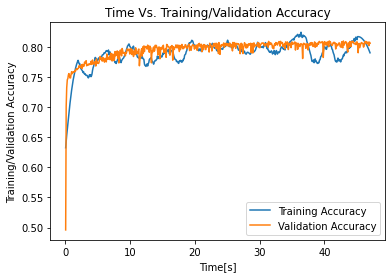

In [ ]:
batch_size = 64 #@param {type:"integer"}

lr = 0.1 #@param {type:"number"}
epochs = 20 #@param {type:"integer"}
eval_every = 10 #@param {type:"integer"}
hidden_layer = 64 #@param {tpye:"integer"}

train_timeplot(batch_size = batch_size, lr=lr,epochs=epochs,
      eval_every = eval_every, hidden_layer = hidden_layer,
      seed=seed,train_filter=True,valid_filter=False)

(Epoch,Batch) = (1,1)
Number of correct predictions: 8841
Avg Training Accuracy (1 most recent batches): 0.493
Validation Accuracy: 0.485
Loss: 0.255


(Epoch,Batch) = (2,1)
Number of correct predictions: 8733
Avg Training Accuracy (1 most recent batches): 0.487
Validation Accuracy: 0.479
Loss: 0.254


(Epoch,Batch) = (3,1)
Number of correct predictions: 8613
Avg Training Accuracy (1 most recent batches): 0.480
Validation Accuracy: 0.475
Loss: 0.253


(Epoch,Batch) = (4,1)
Number of correct predictions: 8529
Avg Training Accuracy (1 most recent batches): 0.476
Validation Accuracy: 0.471
Loss: 0.252


(Epoch,Batch) = (5,1)
Number of correct predictions: 8432
Avg Training Accuracy (1 most recent batches): 0.470
Validation Accuracy: 0.471
Loss: 0.251


(Epoch,Batch) = (6,1)
Number of correct predictions: 8430
Avg Training Accuracy (1 most recent batches): 0.470
Validation Accuracy: 0.477
Loss: 0.251


(Epoch,Batch) = (7,1)
Number of correct predictions: 8496
Avg Training Accuracy (1 most 

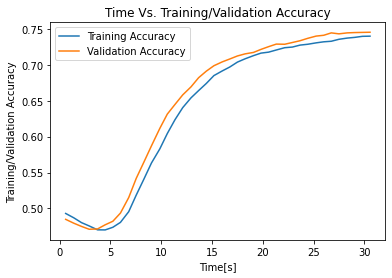

In [ ]:
batch_size = 17932 #@param {type:"integer"}

lr = 0.1 #@param {type:"number"}
epochs = 40 #@param {type:"integer"}
eval_every = 1 #@param {type:"integer"}
hidden_layer = 64 #@param {tpye:"integer"}

train_timeplot(batch_size = batch_size, lr=lr,epochs=epochs,
      eval_every = eval_every, hidden_layer = hidden_layer,
      seed=seed,train_filter=False,valid_filter=False)

## 5.4 Under-fitting

(Epoch,Batch) = (1,10)
Number of correct predictions: 43
Avg Training Accuracy (10 most recent batches): 0.500
Validation Accuracy: 0.609
Loss: 0.242


(Epoch,Batch) = (1,20)
Number of correct predictions: 41
Avg Training Accuracy (10 most recent batches): 0.639
Validation Accuracy: 0.603
Loss: 0.231


(Epoch,Batch) = (1,30)
Number of correct predictions: 37
Avg Training Accuracy (10 most recent batches): 0.658
Validation Accuracy: 0.747
Loss: 0.232


(Epoch,Batch) = (1,40)
Number of correct predictions: 46
Avg Training Accuracy (10 most recent batches): 0.739
Validation Accuracy: 0.744
Loss: 0.214


(Epoch,Batch) = (1,50)
Number of correct predictions: 53
Avg Training Accuracy (10 most recent batches): 0.794
Validation Accuracy: 0.756
Loss: 0.175


(Epoch,Batch) = (1,60)
Number of correct predictions: 48
Avg Training Accuracy (10 most recent batches): 0.731
Validation Accuracy: 0.745
Loss: 0.192


(Epoch,Batch) = (1,70)
Number of correct predictions: 52
Avg Training Accuracy (10 most 

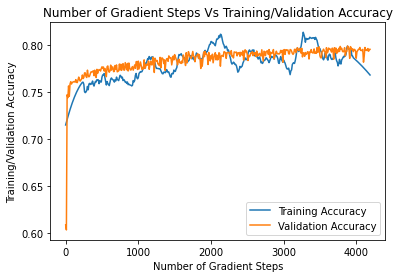

In [ ]:
class MultiLayerPerceptron_no_hidden(nn.Module):
    def __init__(self, input_size):
      super(MultiLayerPerceptron_no_hidden, self).__init__()
      self.layer_out = nn.Linear(input_size,1)
      self.sigmoid = nn.Sigmoid()
    def forward(self, features):
      x = self.layer_out(features)
      x = self.sigmoid(x)
      return x

def load_model_no_hidden(lr):
  model = MultiLayerPerceptron_no_hidden(input_size=103)
  loss_fcn = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(),lr=lr)
  return model, loss_fcn, optimizer

# redefine the main function to train function for ease of calling
def train_no_hidden(batch_size,lr,epochs,eval_every,seed,train_filter,valid_filter):
  
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


  torch.manual_seed(seed)

  train_data = AdultDataset(torch.from_numpy(X_train),torch.from_numpy(y_train))
  test_data = AdultDataset(torch.from_numpy(X_test),torch.from_numpy(y_test))
  train_loader, val_loader = load_data(batch_size=batch_size,train_data=train_data,test_data=test_data)
  model,loss_fcn,optimizer = load_model_no_hidden(lr)
  model.to(device)

  
  trainAccRec = []
  miniTrainAcc = []
  validAccRec = [] 

  tot_corr = 0
  num_batch = 0

  t = []
  tic = time.time()


  model.train()
  for epoch in range (1,epochs+1):
    for i,data in enumerate(train_loader,0):
      inputs,labels = data
      inputs,labels = inputs.to(device), labels.to(device)
      
      optimizer.zero_grad()
      
      predict = model(inputs.float())
      y_pred = np.where(predict > 0.5,1,0)
      
      loss = loss_fcn(input = predict.squeeze(),target=labels.float())
      loss.backward()
      optimizer.step()
      
      
      miniTrainAcc.append(accuracy(y_pred,labels))
      
      if (i % eval_every) == (eval_every - 1):
        num_batch += 1
        trainAcc = accuracy(y_pred,labels.float())
        trainAccRec.append(trainAcc)

        valAcc = evaluate(model,val_loader)
        mini_train_acc = sum(miniTrainAcc) / len(miniTrainAcc)
        validAccRec.append(valAcc)
        
        #t.append(time.time()-tic)
        print("(Epoch,Batch) = (%d,%d)"%(epoch,i+1))
        print("Number of correct predictions: %d"%(count_num_corr_predicts(y_pred,labels)))
        print("Avg Training Accuracy (%d most recent batches): %.3f"%(eval_every,mini_train_acc))
        print("Validation Accuracy: %.3f"%valAcc)
        print("Loss: %.3f"%loss.item())
        print("\n")
        miniTrainAcc = []


  toc = time.time()
  print("Highest Validation Accuracy:%.3f"%max(validAccRec))
  print("Highest Training Accuracy:%.3f"%max(trainAccRec))
  print("Total time:%.3f"%(toc-tic))
  num_batches = list(range(num_batch)) 
  num_steps = [i * eval_every for i in num_batches]
  if (train_filter):
    trainAccRec = savgol_filter(trainAccRec,47,2) 
  if (valid_filter):  
    validAccRec = savgol_filter(validAccRec,47,2) 
    
  plt.plot(num_steps,trainAccRec,label="Training Accuracy")
  plt.plot(num_steps,validAccRec,label="Validation Accuracy")


  plt.legend()
  plt.xlabel("Number of Gradient Steps")
  plt.ylabel("Training/Validation Accuracy")
  plt.title("Number of Gradient Steps Vs Training/Validation Accuracy")
  
batch_size = 64 #@param {type:"integer"}

lr = 0.1 #@param {type:"number"}
epochs = 15 #@param {type:"integer"}
eval_every = 10 #@param {type:"integer"}
hidden_layer = 64 #@param {tpye:"integer"}

train_no_hidden(batch_size = batch_size, lr=lr,epochs=epochs,
                eval_every = eval_every, seed=seed,
                train_filter=True,valid_filter=False)


## 5.5 Over-fitting

(Epoch,Batch) = (1,10)
Number of correct predictions: 38
Avg Training Accuracy (10 most recent batches): 0.506
Validation Accuracy: 0.584
Loss: 0.250


(Epoch,Batch) = (1,20)
Number of correct predictions: 43
Avg Training Accuracy (10 most recent batches): 0.570
Validation Accuracy: 0.501
Loss: 0.249


(Epoch,Batch) = (1,30)
Number of correct predictions: 45
Avg Training Accuracy (10 most recent batches): 0.600
Validation Accuracy: 0.546
Loss: 0.249


(Epoch,Batch) = (1,40)
Number of correct predictions: 41
Avg Training Accuracy (10 most recent batches): 0.608
Validation Accuracy: 0.697
Loss: 0.249


(Epoch,Batch) = (1,50)
Number of correct predictions: 40
Avg Training Accuracy (10 most recent batches): 0.666
Validation Accuracy: 0.542
Loss: 0.248


(Epoch,Batch) = (1,60)
Number of correct predictions: 35
Avg Training Accuracy (10 most recent batches): 0.588
Validation Accuracy: 0.712
Loss: 0.249


(Epoch,Batch) = (1,70)
Number of correct predictions: 47
Avg Training Accuracy (10 most 

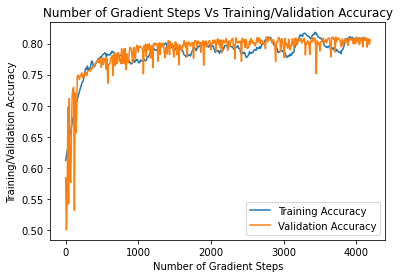

In [ ]:
class MultiLayerPerceptron_many_hidden(nn.Module):
    def __init__(self, input_size,hidden_layer):
      super(MultiLayerPerceptron_many_hidden, self).__init__()
      self.fc1 = nn.Linear(input_size,hidden_layer)
      self.fc2 = nn.Linear(hidden_layer,hidden_layer)
      self.fc3 = nn.Linear(hidden_layer,hidden_layer)
      self.layer_out = nn.Linear(hidden_layer,1)
      self.sigmoid = nn.Sigmoid()
      self.relu = nn.ReLU()
    def forward(self, features):
      x = self.relu(self.fc1(features))
      x = self.relu(self.fc2(x))
      x = self.relu(self.fc3(x))
      x = self.layer_out(x)
      x = self.sigmoid(x)
      return x

def load_model_many_hidden(lr,hidden_layer):
  model = MultiLayerPerceptron_many_hidden(input_size=103,hidden_layer=hidden_layer)
  loss_fcn = nn.MSELoss()
  optimizer = torch.optim.SGD(model.parameters(),lr=lr)
  return model, loss_fcn, optimizer

# redefine the main function to train function for ease of calling
def train_many_hidden(batch_size,lr,epochs,eval_every,hidden_layer,seed,train_filter,valid_filter):
  
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


  torch.manual_seed(seed)

  train_data = AdultDataset(torch.from_numpy(X_train),torch.from_numpy(y_train))
  test_data = AdultDataset(torch.from_numpy(X_test),torch.from_numpy(y_test))
  train_loader, val_loader = load_data(batch_size=batch_size,train_data=train_data,test_data=test_data)
  model,loss_fcn,optimizer = load_model_many_hidden(lr=lr,hidden_layer=hidden_layer)
  model.to(device)

  
  trainAccRec = []
  miniTrainAcc = []
  validAccRec = [] 

  tot_corr = 0
  num_batch = 0

  t = []
  tic = time.time()


  model.train()
  for epoch in range (1,epochs+1):
    for i,data in enumerate(train_loader,0):
      inputs,labels = data
      inputs,labels = inputs.to(device), labels.to(device)
      
      optimizer.zero_grad()
      
      predict = model(inputs.float())
      y_pred = np.where(predict > 0.5,1,0)
      
      loss = loss_fcn(input = predict.squeeze(),target=labels.float())
      loss.backward()
      optimizer.step()
      
      
      miniTrainAcc.append(accuracy(y_pred,labels))
      
      if (i % eval_every) == (eval_every - 1):
        num_batch += 1
        trainAcc = accuracy(y_pred,labels.float())
        trainAccRec.append(trainAcc)

        valAcc = evaluate(model,val_loader)
        mini_train_acc = sum(miniTrainAcc) / len(miniTrainAcc)
        validAccRec.append(valAcc)
        
        #t.append(time.time()-tic)
        print("(Epoch,Batch) = (%d,%d)"%(epoch,i+1))
        print("Number of correct predictions: %d"%(count_num_corr_predicts(y_pred,labels)))
        print("Avg Training Accuracy (%d most recent batches): %.3f"%(eval_every,mini_train_acc))
        print("Validation Accuracy: %.3f"%valAcc)
        print("Loss: %.3f"%loss.item())
        print("\n")
        miniTrainAcc = []


  toc = time.time()
  print("Highest Validation Accuracy:%.3f"%max(validAccRec))
  print("Highest Training Accuracy:%.3f"%max(trainAccRec))
  print("Total time:%.3f"%(toc-tic))
  num_batches = list(range(num_batch)) 
  num_steps = [i * eval_every for i in num_batches]
  if (train_filter):
    trainAccRec = savgol_filter(trainAccRec,47,2) 
  if (valid_filter):  
    validAccRec = savgol_filter(validAccRec,47,2) 
    
  plt.plot(num_steps,trainAccRec,label="Training Accuracy")
  plt.plot(num_steps,validAccRec,label="Validation Accuracy")


  plt.legend()
  plt.xlabel("Number of Gradient Steps")
  plt.ylabel("Training/Validation Accuracy")
  plt.title("Number of Gradient Steps Vs Training/Validation Accuracy")
  
batch_size = 64 #@param {type:"integer"}

lr = 0.1 #@param {type:"number"}
epochs = 15 #@param {type:"integer"}
eval_every = 10 #@param {type:"integer"}
hidden_layer = 64 #@param {tpye:"integer"}

train_many_hidden(batch_size = batch_size, lr=lr,epochs=epochs,
                eval_every = eval_every, hidden_layer = hidden_layer,
                seed=seed,train_filter=True,valid_filter=False)


## 5.6 Activation Function

Streaming output truncated to the last 5000 lines.


(Epoch,Batch) = (5,160)
Number of correct predictions: 25
Avg Training Accuracy (10 most recent batches): 0.436
Validation Accuracy: 0.417
Loss: 0.255


(Epoch,Batch) = (5,170)
Number of correct predictions: 24
Avg Training Accuracy (10 most recent batches): 0.402
Validation Accuracy: 0.417
Loss: 0.254


(Epoch,Batch) = (5,180)
Number of correct predictions: 28
Avg Training Accuracy (10 most recent batches): 0.441
Validation Accuracy: 0.417
Loss: 0.253


(Epoch,Batch) = (5,190)
Number of correct predictions: 33
Avg Training Accuracy (10 most recent batches): 0.448
Validation Accuracy: 0.417
Loss: 0.249


(Epoch,Batch) = (5,200)
Number of correct predictions: 27
Avg Training Accuracy (10 most recent batches): 0.453
Validation Accuracy: 0.417
Loss: 0.251


(Epoch,Batch) = (5,210)
Number of correct predictions: 22
Avg Training Accuracy (10 most recent batches): 0.430
Validation Accuracy: 0.417
Loss: 0.255


(Epoch,Batch) = (5,220)
Numbe

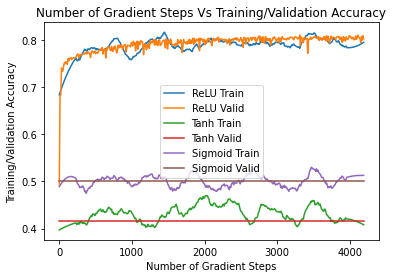

In [148]:
class MultiLayerPerceptron_tanh(nn.Module):
    def __init__(self, input_size,hidden_layer):
      super(MultiLayerPerceptron_tanh, self).__init__()
      self.fc1 = nn.Linear(input_size,hidden_layer)
      self.layer_out = nn.Linear(hidden_layer,1)
      self.sigmoid = nn.Sigmoid()
      self.tanh = nn.Tanh()
    def forward(self, features):
      x = self.tanh(self.fc1(features))
      x = self.layer_out(x)
      x = self.sigmoid(x)
      return x

class MultiLayerPerceptron_sigmoid(nn.Module):
    def __init__(self, input_size,hidden_layer):
      super(MultiLayerPerceptron_sigmoid, self).__init__()
      self.fc1 = nn.Linear(input_size,hidden_layer)
      self.layer_out = nn.Linear(hidden_layer,1)
      self.sigmoid = nn.Sigmoid()
    def forward(self, features):
      x = self.sigmoid(self.fc1(features))
      x = self.layer_out(x)
      x = self.sigmoid(x)
      return x


def train_many_models(batch_size,lr,epochs,eval_every,hidden_layer,seed,train_filter,valid_filter):
  
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


  torch.manual_seed(seed)

  train_data = AdultDataset(torch.from_numpy(X_train),torch.from_numpy(y_train))
  test_data = AdultDataset(torch.from_numpy(X_test),torch.from_numpy(y_test))
  train_loader, val_loader = load_data(batch_size=batch_size,train_data=train_data,test_data=test_data)
  model,loss_fcn,optimizer = load_model(lr=lr,hidden_layer=hidden_layer)
  model2 = MultiLayerPerceptron_tanh(input_size=103,hidden_layer=hidden_layer)
  model3 = MultiLayerPerceptron_sigmoid(input_size=103,hidden_layer=hidden_layer)

  model.to(device)
  model2.to(device)
  model3.to(device)


  
  trainAccRec = []
  miniTrainAcc = []
  validAccRec = [] 

  tot_corr = 0
  num_batch = 0

  t = []
  tic = time.time()

  #ReLU model training
  model.train()
  for epoch in range (1,epochs+1):
    for i,data in enumerate(train_loader,0):
      inputs,labels = data
      inputs,labels = inputs.to(device), labels.to(device)
      
      optimizer.zero_grad()
      
      predict = model(inputs.float())
      y_pred = np.where(predict > 0.5,1,0)
      
      loss = loss_fcn(input = predict.squeeze(),target=labels.float())
      loss.backward()
      optimizer.step()
      
      
      miniTrainAcc.append(accuracy(y_pred,labels))
      
      if (i % eval_every) == (eval_every - 1):
        num_batch += 1
        trainAcc = accuracy(y_pred,labels.float())
        trainAccRec.append(trainAcc)

        valAcc = evaluate(model,val_loader)
        mini_train_acc = sum(miniTrainAcc) / len(miniTrainAcc)
        validAccRec.append(valAcc)
        
        #t.append(time.time()-tic)
        print("(Epoch,Batch) = (%d,%d)"%(epoch,i+1))
        print("Number of correct predictions: %d"%(count_num_corr_predicts(y_pred,labels)))
        print("Avg Training Accuracy (%d most recent batches): %.3f"%(eval_every,mini_train_acc))
        print("Validation Accuracy: %.3f"%valAcc)
        print("Loss: %.3f"%loss.item())
        print("\n")
        miniTrainAcc = []


  toc = time.time()
  print("Highest Validation Accuracy:%.3f"%max(validAccRec))
  print("Highest Training Accuracy:%.3f"%max(trainAccRec))
  print("Total time:%.3f"%(toc-tic))
  num_batches = list(range(num_batch)) 
  num_steps = [i * eval_every for i in num_batches]
  if (train_filter):
    trainAccRec = savgol_filter(trainAccRec,47,2) 
  if (valid_filter):  
    validAccRec = savgol_filter(validAccRec,47,2) 


  #tanh model training
  trainAccRec2 = []
  miniTrainAcc = []
  validAccRec2 = [] 

  tot_corr = 0
  num_batch = 0

  t = []
  tic = time.time()


  model2.train()
  for epoch in range (1,epochs+1):
    for i,data in enumerate(train_loader,0):
      inputs,labels = data
      inputs,labels = inputs.to(device), labels.to(device)
      
      optimizer.zero_grad()
      
      predict = model2(inputs.float())
      y_pred = np.where(predict > 0.5,1,0)
      
      loss = loss_fcn(input = predict.squeeze(),target=labels.float())
      loss.backward()
      optimizer.step()
      
      
      miniTrainAcc.append(accuracy(y_pred,labels))
      
      if (i % eval_every) == (eval_every - 1):
        num_batch += 1
        trainAcc = accuracy(y_pred,labels.float())
        trainAccRec2.append(trainAcc)

        valAcc = evaluate(model2,val_loader)
        mini_train_acc = sum(miniTrainAcc) / len(miniTrainAcc)
        validAccRec2.append(valAcc)
        
        #t.append(time.time()-tic)
        print("(Epoch,Batch) = (%d,%d)"%(epoch,i+1))
        print("Number of correct predictions: %d"%(count_num_corr_predicts(y_pred,labels)))
        print("Avg Training Accuracy (%d most recent batches): %.3f"%(eval_every,mini_train_acc))
        print("Validation Accuracy: %.3f"%valAcc)
        print("Loss: %.3f"%loss.item())
        print("\n")
        miniTrainAcc = []


  toc = time.time()
  print("Highest Validation Accuracy:%.3f"%max(validAccRec2))
  print("Highest Training Accuracy:%.3f"%max(trainAccRec2))
  print("Total time:%.3f"%(toc-tic))
  num_batches = list(range(num_batch)) 
  num_steps = [i * eval_every for i in num_batches]
  if (train_filter):
    trainAccRec2 = savgol_filter(trainAccRec2,47,2) 
  if (valid_filter):  
    validAccRec2 = savgol_filter(validAccRec2,47,2) 


  trainAccRec3 = []
  miniTrainAcc = []
  validAccRec3 = [] 

  tot_corr = 0
  num_batch = 0

  t = []
  tic = time.time()

  #Sigmoid model training

  model3.train()
  for epoch in range (1,epochs+1):
    for i,data in enumerate(train_loader,0):
      inputs,labels = data
      inputs,labels = inputs.to(device), labels.to(device)
      
      optimizer.zero_grad()
      
      predict = model3(inputs.float())
      y_pred = np.where(predict > 0.5,1,0)
      
      loss = loss_fcn(input = predict.squeeze(),target=labels.float())
      loss.backward()
      optimizer.step()
      
      
      miniTrainAcc.append(accuracy(y_pred,labels))
      
      if (i % eval_every) == (eval_every - 1):
        num_batch += 1
        trainAcc = accuracy(y_pred,labels.float())
        trainAccRec3.append(trainAcc)

        valAcc = evaluate(model3,val_loader)
        mini_train_acc = sum(miniTrainAcc) / len(miniTrainAcc)
        validAccRec3.append(valAcc)
        
        #t.append(time.time()-tic)
        print("(Epoch,Batch) = (%d,%d)"%(epoch,i+1))
        print("Number of correct predictions: %d"%(count_num_corr_predicts(y_pred,labels)))
        print("Avg Training Accuracy (%d most recent batches): %.3f"%(eval_every,mini_train_acc))
        print("Validation Accuracy: %.3f"%valAcc)
        print("Loss: %.3f"%loss.item())
        print("\n")
        miniTrainAcc = []


  toc = time.time()
  print("Highest Validation Accuracy:%.3f"%max(validAccRec3))
  print("Highest Training Accuracy:%.3f"%max(trainAccRec3))
  print("Total time:%.3f"%(toc-tic))
  num_batches = list(range(num_batch)) 
  num_steps = [i * eval_every for i in num_batches]
  if (train_filter):
    trainAccRec3 = savgol_filter(trainAccRec3,47,2) 
  if (valid_filter):  
    validAccRec3 = savgol_filter(validAccRec3,47,2) 


    
  plt.plot(num_steps,trainAccRec,label="ReLU Train")
  plt.plot(num_steps,validAccRec,label="ReLU Valid")
  plt.plot(num_steps,trainAccRec2,label="Tanh Train")
  plt.plot(num_steps,validAccRec2,label="Tanh Valid")
  plt.plot(num_steps,trainAccRec3,label="Sigmoid Train")
  plt.plot(num_steps,validAccRec3,label="Sigmoid Valid")


  plt.legend()
  plt.xlabel("Number of Gradient Steps")
  plt.ylabel("Training/Validation Accuracy")
  plt.title("Number of Gradient Steps Vs Training/Validation Accuracy")

  
batch_size = 64 #@param {type:"integer"}

lr = 0.1 #@param {type:"number"}
epochs = 15 #@param {type:"integer"}
eval_every = 10 #@param {type:"integer"}
hidden_layer = 64 #@param {tpye:"integer"}

train_many_models(batch_size = batch_size, lr=lr,epochs=epochs,
                eval_every = eval_every, hidden_layer = hidden_layer,
                seed=seed,train_filter=True,valid_filter=False)


## 5.7 Hyperparamter search

(Epoch,Batch) = (1,10)
Number of correct predictions: 32
Avg Training Accuracy (10 most recent batches): 0.511
Validation Accuracy: 0.496
Loss: 0.247


(Epoch,Batch) = (1,20)
Number of correct predictions: 41
Avg Training Accuracy (10 most recent batches): 0.588
Validation Accuracy: 0.701
Loss: 0.243


(Epoch,Batch) = (1,30)
Number of correct predictions: 44
Avg Training Accuracy (10 most recent batches): 0.650
Validation Accuracy: 0.732
Loss: 0.238


(Epoch,Batch) = (1,40)
Number of correct predictions: 40
Avg Training Accuracy (10 most recent batches): 0.711
Validation Accuracy: 0.746
Loss: 0.233


(Epoch,Batch) = (1,50)
Number of correct predictions: 46
Avg Training Accuracy (10 most recent batches): 0.730
Validation Accuracy: 0.748
Loss: 0.227


(Epoch,Batch) = (1,60)
Number of correct predictions: 44
Avg Training Accuracy (10 most recent batches): 0.725
Validation Accuracy: 0.754
Loss: 0.226


(Epoch,Batch) = (1,70)
Number of correct predictions: 45
Avg Training Accuracy (10 most 

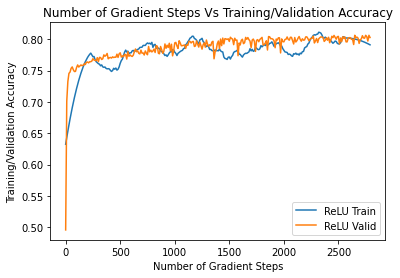

In [ ]:
# best model
batch_size = 64 #@param {type:"integer"}

lr = 0.10 #@param {type:"number"}
epochs = 10 #@param {type:"integer"}
eval_every = 10 #@param {type:"integer"}
hidden_layer = 64 #@param {tpye:"integer"}

train(batch_size = batch_size, lr=lr,epochs=epochs,
      eval_every = eval_every, hidden_layer = hidden_layer,
      seed=seed,train_filter=True,valid_filter=False)